In [3]:
# https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/ Building dataset from
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/oxbuildings/paris_2.tgz
/kaggle/input/oxbuildings/paris_1.tgz
/kaggle/input/oxbuildings/oxbuild_images.tgz


In [4]:
import tarfile

file = tarfile.open("/kaggle/input/oxbuildings/paris_1.tgz")
file.extractall("./kaggle/working/ox")

In [5]:
file = tarfile.open("/kaggle/input/oxbuildings/paris_2.tgz")
file.extractall("./kaggle/working/ox")

In [6]:
import os
import numpy as np
from PIL import Image, UnidentifiedImageError

def convert_image_to_array(file_path):
    try:
        with Image.open(file_path) as image:
            return np.array(image)
    except UnidentifiedImageError:
        print(f"Lỗi: Không thể xác định file ảnh tại {file_path}")
        return None
    except Exception as e:
        print(f"Lỗi không xác định tại {file_path}: {e}")
        return None

directory_path = '/kaggle/working/kaggle/working/ox'

image_data_list = []

for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            
            image_array = convert_image_to_array(file_path)
            if image_array is None:  # Bỏ qua file lỗi
                continue
            
            # Gán nhãn từ tên file (dựa vào phần trước ký tự `_`)
            label = file.split('_')[1]
            
            image_data = {'label': label, 'image_array': image_array}
            
            image_data_list.append(image_data)

print(f"Đã xử lý {len(image_data_list)} ảnh hợp lệ.")


Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000196.jpg
Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000467.jpg
Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000640.jpg
Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000201.jpg
Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000195.jpg
Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/pantheon/paris_pantheon_000960.jpg
Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/pantheon/paris_pantheon_000284.jpg
Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/pantheon/paris_pantheon_000974.jpg
Lỗi: Không thể xác định file ảnh tại /kaggle/working/kaggle/working/ox/paris/notredame/paris_notredame_0

In [7]:
df = pd.DataFrame(image_data_list)
df.head()

,label,image_array
0,pompidou,"[[[134, 119, 214], [232, 228, 255], [254, 254,..."
1,pompidou,"[[[144, 156, 146], [140, 151, 143], [135, 142,..."
2,pompidou,"[[[113, 152, 195], [113, 150, 194], [114, 148,..."
3,pompidou,"[[[21, 29, 42], [20, 32, 44], [22, 35, 44], [3..."
4,pompidou,"[[[106, 131, 185], [100, 138, 187], [90, 149, ..."


In [8]:
df.label.value_counts()

label
general        1497
museedorsay     739
pantheon        659
triomphe        550
invalides       452
moulinrouge     444
notredame       444
pompidou        436
defense         381
sacrecoeur      377
louvre          266
eiffel          147
Name: count, dtype: int64

In [9]:
# the other buildings we'll just call them as they are and drop the oxford city 
df = df[df['label'] != 'general']
df.loc[df['label'] == 'museedorsay', 'label'] = 'musee dorsay'  
df.loc[df['label'] == 'pantheon', 'label'] = 'pantheon paris'  
df.loc[df['label'] == 'triomphe', 'label'] = 'arc de triomphe'  
df.loc[df['label'] == 'invalides', 'label'] = 'hotel des invalides'  
df.loc[df['label'] == 'moulinrouge', 'label'] = 'moulin rouge cabaret'  
df.loc[df['label'] == 'notredame', 'label'] = 'notre dame de paris'  
df.loc[df['label'] == 'pompidou', 'label'] = 'centre georges pompidou'  
df.loc[df['label'] == 'defense', 'label'] = 'la defense district'  
df.loc[df['label'] == 'sacrecoeur', 'label'] = 'basilica of sacre coeur'  
df.loc[df['label'] == 'louvre', 'label'] = 'louvre museum'  
df.loc[df['label'] == 'eiffel', 'label'] = 'eiffel tower'  



In [10]:
df.label.value_counts()

label
musee dorsay               739
pantheon paris             659
arc de triomphe            550
hotel des invalides        452
notre dame de paris        444
moulin rouge cabaret       444
centre georges pompidou    436
la defense district        381
basilica of sacre coeur    377
louvre museum              266
eiffel tower               147
Name: count, dtype: int64

In [11]:
text_labels = df.label.unique().tolist()

In [19]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import torch
from tqdm import tqdm

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.fromarray(row['image_array']).convert('RGB') 
        if self.transform:
            image = self.transform(image)
        text = row['label']
        encoded_text = self.tokenizer(text, padding='max_length', max_length=77, truncation=True, return_tensors="pt")
        return image, encoded_text.input_ids.squeeze(0), encoded_text.attention_mask.squeeze(0)

model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])
dataset = CustomImageDataset(dataframe=df, tokenizer=processor.tokenizer, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
loss_fn = torch.nn.CrossEntropyLoss()

device = torch.device("cuda")
model.to(device)

epochs = 3
for epoch in range(epochs):
    model.train()
    loop = tqdm(dataloader, leave=True)
    for images, input_ids, attention_mask in loop:
        images, input_ids, attention_mask = images.to(device), input_ids.to(device), attention_mask.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=images, return_dict=True)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text
        ground_truth = torch.arange(len(images)).to(device)
        loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item())

Epoch [3/3]: 100%|██████████| 153/153 [01:53<00:00,  1.34it/s, loss=1.55]


In [21]:
model_save_path = "/kaggle/working/paris_clip.pth"
torch.save(model, model_save_path)

In [22]:
%%capture
model.eval()
device = torch.device("cuda")
model.to(device)

In [41]:
from PIL import Image
import requests
url = "https://www.toureiffel.paris/themes/custom/tour_eiffel/build/images/home-discover-bg.jpg"

In [42]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import CLIPProcessor

processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

image_photo = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image = transform(image_photo).unsqueeze(0).to(device)

text_inputs = processor(text=text_labels, return_tensors="pt", padding=True).to(device)

In [43]:
with torch.no_grad():
    image_features = model.get_image_features(image)
    text_features = model.get_text_features(**text_inputs)
    
    similarity = (image_features @ text_features.T).softmax(dim=-1)
    probabilities = similarity.cpu().numpy()

print("Similarity probabilities:", probabilities)

Similarity probabilities: [[1.1570845e-04 8.1700557e-01 5.5908997e-05 1.1426168e-03 2.2996992e-03
  1.6891342e-01 2.3541765e-03 9.6886116e-04 1.0159990e-03 5.5845748e-03
  5.4338749e-04]]


In [51]:
import torch
import pickle

# Giả sử bạn có model và hàm trích xuất feature
# model.get_image_features(image) cho ra tensor torch.Size([1, 512])

# Danh sách lưu feature và tên ảnh

for folder in os.listdir(os.path.join(directory_path,'paris')):
    folder_path = os.path.join(directory_path,'paris', folder)
    image_features_data = []
    for file in os.listdir(folder_path):
        if file.endswith('.jpg'):
            image_path = os.path.join(folder_path, file)
            
            try:
                # Mở ảnh bằng PIL
                image = Image.open(image_path).convert("RGB")
                
                # Áp dụng transform để chuyển đổi ảnh thành tensor
                image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension, [1, 3, H, W]
                
                # Trích xuất feature
                with torch.no_grad():
                    image_feature = model.get_image_features(image_tensor)  # [1, 512]
                
                # Lưu tên ảnh và feature
                image_features_data.append({
                    "image_name": os.path.basename(image_path),  # Lấy tên file từ đường dẫn
                    "features": image_feature.squeeze().cpu().numpy()  # Chuyển thành numpy array
                })
            except Exception as e:
                print(f"Không thể xử lý ảnh {image_path}: {e}")
        
    # Lưu dữ liệu vào file bằng pickle
    output_file = f"{folder}.pkl"
    with open(output_file, "wb") as f:
        pickle.dump(image_features_data, f)

    print(f"Đã lưu {len(image_features_data)} ảnh vào {output_file}.")
    


Không thể xử lý ảnh /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000196.jpg: cannot identify image file '/kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000196.jpg'
Không thể xử lý ảnh /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000467.jpg: cannot identify image file '/kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000467.jpg'
Không thể xử lý ảnh /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000640.jpg: cannot identify image file '/kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000640.jpg'
Không thể xử lý ảnh /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000201.jpg: cannot identify image file '/kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000201.jpg'
Không thể xử lý ảnh /kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000195.jpg: cannot identify image file '/kaggle/working/kaggle/working/ox/paris/pompidou/paris_pompidou_000195.jpg'


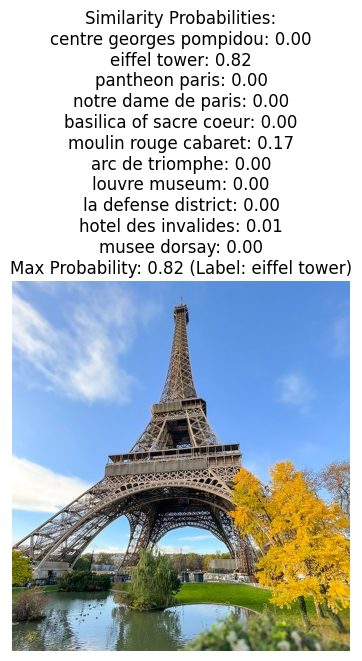

In [52]:
from PIL import Image
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(image_photo)
ax.axis('off')

max_prob = probabilities.max()  
max_index = probabilities.argmax()  
max_label = text_labels[max_index]

title_text = '\n'.join([f'{label}: {prob:.2f}' for label, prob in zip(text_labels, probabilities[0])])
title_text += f'\nMax Probability: {max_prob:.2f} (Label: {max_label})' 
ax.set_title("Similarity Probabilities:\n" + title_text)

plt.show()

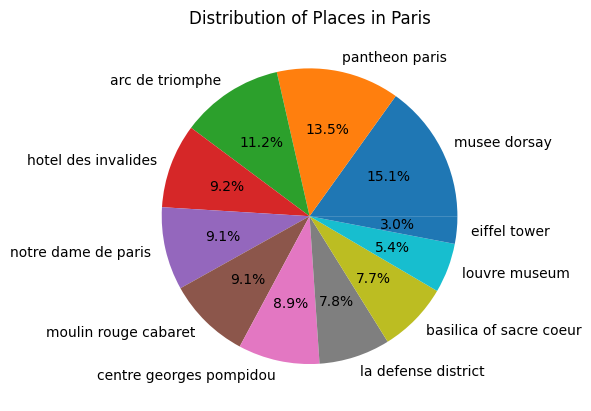

In [53]:
# Hmm. let's try to figure out why this could be the case. Let's look at our data distribution in a pie chart. 
import matplotlib.pyplot as plt
slice_labels = df['label'].value_counts(dropna=False).keys().tolist()
slice_values = df['label'].value_counts(dropna=False).values.tolist() 

plt.pie(slice_values, labels=slice_labels, autopct="%1.1f%%")
plt.title("Distribution of Places in Paris")
plt.show()